In [1]:
using ForneyLab, Plots, ForwardDiff
import Distributions

In [31]:
#synthetic dataset
T = 120

A = 1.0
B = 0.25

v_z = 0.5
v_x = 0.5

z = [5.0]
x = [rand(Distributions.Normal(B*z[1],sqrt(v_x)))]
y = [rand(Distributions.Poisson(exp(x[1])))]

for t=1:(T-1)
    append!(z, rand(Distributions.Normal(A*z[end],sqrt(v_z))))
    append!(x, rand(Distributions.Normal(B*z[end],sqrt(v_x))))
    append!(y, rand(Distributions.Poisson(exp(x[end]))))
end

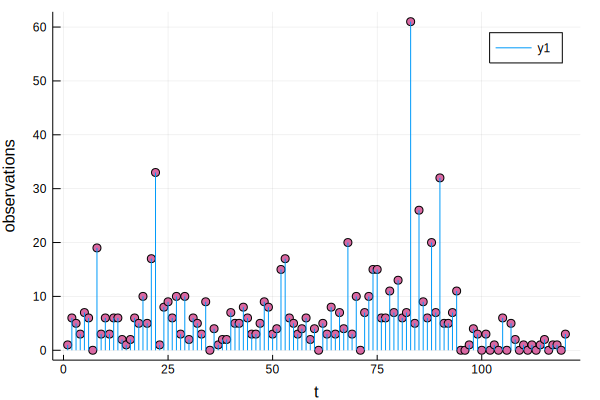

In [32]:
plot(collect(1:T), y, seriestype=:stem, markershape=:circle)
xlabel!("t")
ylabel!("observations")

In [33]:
@composite N_POexp (y, z, nx) begin
    @RV y ~ Poisson(exp(B*z+ nx))
end

In [35]:
using ForneyLab

g = FactorGraph()

# declare priors as random variables
@RV m_z_t_min # m_z_t_min = Variable(id=:m_z_t_min)
@RV v_z_t_min # v_z_t_min = Variable(id=:v_z_t_min)
@RV z_t_min ~ GaussianMeanVariance(m_z_t_min, v_z_t_min)

# System equations
# u = 1.0; v = 200.0
@RV n_t_z ~ GaussianMeanVariance(0.0, 0.8)
@RV n_t_x ~ GaussianMeanVariance(0.0, 0.8)
@RV z_t = A*z_t_min + n_t_z
@RV y_t ~ N_POexp(z_t,n_t_x)

# Placeholders for prior
placeholder(m_z_t_min, :m_z_t_min) # placeholder(:m_x_t_min) does not work
placeholder(v_z_t_min, :v_z_t_min)

# Placeholder for data
placeholder(y_t, :y_t);

In [36]:
@sumProductRule(:node_type     => N_POexp,                                 # our custom composite node
                :outbound_type => Message{Gaussian},               # this rule produces a Poisson msg
                :inbound_types => (Message{PointMass}, Nothing, Message{Gaussian}), # msg towards first interface, incoming types
                :name          => SPNPOexpIn1VGG)  

SPNPOexpIn1VGG

In [37]:
function ForneyLab.collectSumProductNodeInbounds(node::N_POexp, entry::ScheduleEntry, interface_to_msg_idx::Dict{Interface, Int})
    inbound_messages = String[]
    for node_interface in node.interfaces
        inbound_interface = ultimatePartner(node_interface)
        if node_interface == node.interfaces[2]
            # Always collect the message inbound on the in1 edge,
            # because it is used to obtain the approximation point
            haskey(interface_to_msg_idx, inbound_interface) || error("The nonlinear node's backward rule uses the incoming message on the input edge to determine the approximation point. Try altering the variable order in the scheduler to first perform a forward pass.")
            inbound_idx = interface_to_msg_idx[inbound_interface]
            push!(inbound_messages, "messages[$inbound_idx]")
        elseif node_interface == entry.interface
            # Ignore inbound message on outbound interface
            push!(inbound_messages, "nothing")
        elseif isa(inbound_interface.node, Clamp)
            # Hard-code outbound message of constant node in schedule
            push!(inbound_messages, ForneyLab.messageString(inbound_interface.node))
        else
            # Collect message from previous result
            inbound_idx = interface_to_msg_idx[inbound_interface]
            push!(inbound_messages, "messages[$inbound_idx]")
        end
    end

    return inbound_messages
end

In [38]:
function find_factorial(x)
    mult = 1.0
    if x==0
        return mult
    else
        for i=1:x
            mult = mult*i
        end
        return mult
    end
end

find_factorial (generic function with 1 method)

In [39]:
#differentiable reparameterization function for Gaussian
function g_func(epsilon, a, b)
    return a + b*epsilon
end

g_func (generic function with 1 method)

In [40]:
#approximating exact marginal posterior with gaussian q and auto-vi
function gaussian_avi(log_fA, log_fB, mu_prior, v_prior, eta_a, eta_b, num_epoch, num_epoch2)
    sum_a = 0
    sum_b = 0
    a_t = mu_prior
    b_t = sqrt(v_prior)
    for epoch2=1:num_epoch2
        for epoch=1:num_epoch
            message_6 = rand(Distributions.Normal(0,1),1)[1]
            epsilon = message_6
            message_7 = a_t
            message_8 = b_t
            message_9 = g_func(message_6, message_7, message_8)
            x_sample = message_9
            message_10 = x_sample
            message_11 = x_sample
            message_1 = ForwardDiff.derivative(log_fA, x_sample)
            message_2 = ForwardDiff.derivative(log_fB, x_sample)
            message_3 = message_1 + message_2
            g_a(a) = g_func(epsilon, a, b_t)
            message_4 = message_3 * ForwardDiff.derivative(g_a, a_t)
            g_b(b) = g_func(epsilon, a_t, b)
            message_5 = message_3 * ForwardDiff.derivative(g_b, b_t) + 1.0/b_t
            sum_a += message_4
            sum_b += message_5
        end
        a_t = a_t + eta_a*sum_a/num_epoch
        b_t = b_t + eta_b*sum_b/num_epoch
    end
    return a_t, b_t^2
end

gaussian_avi (generic function with 1 method)

In [41]:
function ruleSPNPOexpIn1VGG(msg_out::Message{F1, V},msg_z::Message{F2, V},msg_nx::Message{F2, V}) where {F1<:PointMass, F2<:Gaussian, V<:Univariate}
    
    log_fB(y,s) = y*log(exp(s)) - exp(s) - log(find_factorial(y))
    fA(mu,v,s) = Distributions.pdf(Distributions.Normal(mu, v),s)
    obs = msg_out.dist.params[:m]
    log_FB(s) = log_fB(obs,s)
    #deneme = ForwardDiff.derivative(log_FB, obs)
    x = convert(ProbabilityDistribution{V, GaussianMeanVariance}, msg_z.dist)
    nx = convert(ProbabilityDistribution{V, GaussianMeanVariance}, msg_nx.dist)
    x_m = B*x.params[:m]
    nx_v = nx.params[:v]
    x_v = B^2 * x.params[:v] + nx_v
    log_FA(s) = log(fA(x_m,x_v,s))
    mu_xt, v_xt = gaussian_avi(log_FA, log_FB, x_m, x_v, 0.001, 0.000001, 50, 500)
    nu_zt, vu_zt = mu_xt/B, nx_v/(B^2)
    Message(V, GaussianMeanVariance, m=nu_zt, v=vu_zt)
end

ruleSPNPOexpIn1VGG (generic function with 1 method)

In [42]:
shortcut_schedule = sumProductSchedule(z_t)

println(shortcut_schedule)

	SPClamp{Univariate} on Interface 1 (out) of Clamp{Univariate} clamp_1
	SPClamp{Univariate} on Interface 1 (out) of Clamp{Univariate} clamp_2
1.	SPGaussianMeanVarianceOutVPP on Interface 1 (out) of GaussianMeanVariance gaussianmeanvariance_2
	SPClamp{Univariate} on Interface 1 (out) of Clamp{Univariate} clamp_5
	SPClamp{Univariate} on Interface 1 (out) of Clamp{Univariate} placeholder_m_z_t_min
	SPClamp{Univariate} on Interface 1 (out) of Clamp{Univariate} placeholder_v_z_t_min
2.	SPGaussianMeanVarianceOutVPP on Interface 1 (out) of GaussianMeanVariance gaussianmeanvariance_1
3.	SPMultiplicationOutVGP on Interface 1 (out) of Multiplication multiplication_1
4.	SPAdditionOutVGG on Interface 1 (out) of Addition addition_1
	SPClamp{Univariate} on Interface 1 (out) of Clamp{Univariate} clamp_3
	SPClamp{Univariate} on Interface 1 (out) of Clamp{Univariate} clamp_4
5.	SPGaussianMeanVarianceOutVPP on Interface 1 (out) of GaussianMeanVariance gaussianmeanvariance_3
	SPClamp{Univariate} on Inter

In [43]:
algo = sumProductAlgorithm(z_t)
eval(Meta.parse(algo)) # Load algorithm

println(algo) # Inspect the algorithm

begin

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 6))

messages[1] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=0.8))
messages[2] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=data[:m_z_t_min]), Message(Univariate, PointMass, m=data[:v_z_t_min]))
messages[3] = ruleSPMultiplicationOutVGP(nothing, messages[2], Message(Univariate, PointMass, m=1.0))
messages[4] = ruleSPAdditionOutVGG(nothing, messages[3], messages[1])
messages[5] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=0.8))
messages[6] = ruleSPNPOexpIn1VGG(Message(Univariate, PointMass, m=data[:y_t]), messages[4], messages[5])

marginals[:z_t] = messages[4].dist * messages[6].dist

return marginals

end

end # block


In [44]:
# Define values for prior statistics
m_z_0 = 0.0
v_z_0 = 20.0

m_z = Vector{Float64}(undef, T)
v_z = Vector{Float64}(undef, T)

m_z_t_min = m_z_0
v_z_t_min = v_z_0
for t = 1:T
    # Prepare data and prior statistics
    data = Dict(:y_t       => y[t],
                :m_z_t_min => m_z_t_min,
                :v_z_t_min => v_z_t_min)
    
    # Execute algorithm
    marginals = step!(data)

    # Extract posterior statistics
    m_z_t_min = mean(marginals[:z_t])
    v_z_t_min = var(marginals[:z_t])
    
    # Store to buffer 
    m_z[t] = m_z_t_min
    v_z[t] = v_z_t_min
end

In [45]:
m_z

120-element Array{Float64,1}:
  0.23909879628273223
  1.2593010469569568 
  2.859486735958631  
  3.1924506849925685 
  3.9408684276976347 
  5.034621640194261  
  3.689574190392883  
  3.3040481639173724 
  3.6326283939603607 
  4.45373934958788   
  4.3970311924270655 
  5.17139997349241   
  5.586157001874569  
  ⋮                  
 -0.39233950913703763
 -0.6816033519481821 
 -1.3095693128602015 
 -1.4387190502045524 
 -1.7538319980527894 
 -1.6330007232750887 
 -1.4871995873188515 
 -1.7392475221445185 
 -2.077901330415729  
 -2.1430616842826327 
 -2.1363636051567445 
 -0.7593613638428206 

In [47]:
anim = @animate for i = 1:T
    s = plot()
    plot!(collect(1:i), z[1:i], color = :magenta, linewidth = 3, label="true z", xlims=(0,T), ylims=(-5,15))
    plot!([m_z[1:i],m_z[1:i]],color=:black, linestyle=:dash,linewidth = 2,label="inferred z",fillrange = [m_z[1:i]-sqrt.(v_z[1:i]),m_z[1:i]+sqrt.(v_z[1:i])],
        fillalpha = 0.2,
        fillcolor = :red)
    xlabel!("t")
    ylabel!("hidden states")
end
gif(anim, "plds_forney.gif", fps = 5)

┌ Info: Saved animation to 
│   fn = /Users/sakbayrak/Codes/ForneyLab examples/plds_forney.gif
└ @ Plots /Users/sakbayrak/.julia/packages/Plots/UQI78/src/animation.jl:90


Plots.AnimatedGif("/Users/sakbayrak/Codes/ForneyLab examples/plds_forney.gif")